## Segmenting and Clustering Neighborhoods in Toronto

In this notebook, we will be segmenting and clustering the neighborhoods in the city of Toronto based on their features. 

### Getting postal codes for boroughs and neighborhoods in Toronto

Since this data is not avilable in a structured file format, we will obtain this information from the following Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. The Beautiful Soup package can be used to parse any html or xml file and store the results in a Pandas dataframe.

In [13]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

In [14]:
wiki_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(wiki_url).text

# there is one table on this page so it's easy to find
soup = BeautifulSoup(source, 'xml')
table_tab = str(soup.table)

Read the html tables into Pandas dataframes

In [20]:
table_dfs = pd.read_html(table_tab)
print('Number of tables in html:', len(table_dfs))

Number of tables in html: 1


In [21]:
# read the first 
df_raw = table_dfs[0]
df_raw.head(10)

,0,1,2
0,Postal Code,Borough,Neighborhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M8A,Not assigned,Not assigned
9,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"


### Cleaning the dataframe

The table consists of three columns: PostalCode, Borough, and Neighborhood. 

* We will only process the cells that have an assigned borough and ignore cells with a borough that is Not assigned. 
* One neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma. 
* If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough

In [22]:
# Fix the headers and drop the first row
df_raw.columns = ['Postal Code', 'Borough', 'Neighborhood']
df_raw.drop(df_raw.index[0], inplace=True)
df_raw.head()

,Postal Code,Borough,Neighborhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [23]:
# Drop the rows where borough is 'Not assigned'
df = df_raw[df_raw.Borough != 'Not assigned']
df.head()

,Postal Code,Borough,Neighborhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [24]:
# Next combine the neighbourhoods with same postalcode
df = df.groupby(['Postal Code','Borough'], sort=False).agg(', '.join)
df.reset_index(inplace=True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [25]:
# Replace the name of the neighbourhoods which are 'Not assigned' with names of Borough
df['Neighborhood'] = np.where(df['Neighborhood'] == 'Not assigned', df['Borough'], df['Neighborhood'])
df.head(30)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [26]:
df.shape

(103, 3)

### Getting the Latitude and Longitude of each Neighborhood

In order to use location data, we need to first get the latitude and longitude data for each neighborhood. We will import this from a csv file.

In [27]:
geo_coord_df = pd.read_csv("data/Toronto_Geospatial_Coordinates.csv")
geo_coord_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the geo coordinates and neighborhoods dataframe on postal code. 

In [28]:
df = pd.merge(df, geo_coord_df, on='Postal Code')
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [29]:
df.shape

(103, 5)

### Look at all the Boroughs with the word 'Toronto' in them

In [59]:
toronto_df = df[df['Borough'].str.contains("Toronto")]
toronto_df.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
31,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259


In [173]:
toronto_df.shape

(39, 5)

### Visualize the map of neighborhoods in Toronto with Folium

In [174]:
toronto_map = folium.Map(location=[43.650571,-79.384568],zoom_start=11)

for lat,lng,borough,neighborhood in zip(toronto_df['Latitude'],toronto_df['Longitude'],toronto_df['Borough'],toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(toronto_map)
toronto_map

The map does not show in Github, so here's an image of it:
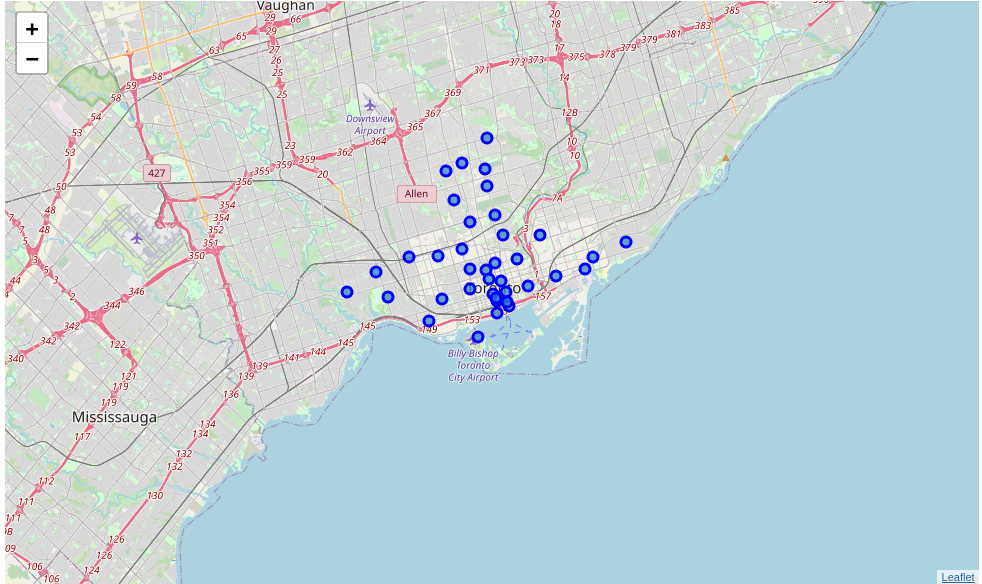

### Explore Venues in Toronto using Location Data from Foursquare API

In [175]:
# the following method uses the Foursquare API to get some venues nearby a given location
def getNearbyVenues(client_id, client_secret, version, names, latitudes, longitudes, radius=100, limit=20):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [128]:
client_id = '1VJXHOYL2MN3CJLNT2WQULQUVH23FXNYFF4TXUJ1SGODM4OT' # your Foursquare ID
client_secret = 'M0PEUL50VU0UGFYSACJCJWTJ5OL33NSJVTIQAZOPOKROZLCU' # your Foursquare Secret
version = '20180604'\

# restrict venues to specific area in downtown
latitude = 43.653963
longitude = -79.387207

toronto_venues = getNearbyVenues(client_id=client_id,
                                  client_secret=client_secret,
                                  version=version,
                                  names=toronto_df['Neighborhood'],
                                  latitudes=toronto_df['Latitude'],
                                  longitudes=toronto_df['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

Let's see how many venues we have in each neighborhood

In [176]:
print(toronto_venues.shape)
toronto_venues.head()

(103, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
1,"Regent Park, Harbourfront",43.654260,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
2,"Garden District, Ryerson",43.657162,-79.378937,Ryerson Image Centre,43.657523,-79.379460,Art Gallery
3,"Garden District, Ryerson",43.657162,-79.378937,Balzac's Coffee,43.657854,-79.379200,Coffee Shop
4,St. James Town,43.651494,-79.375418,Gyu-Kaku Japanese BBQ,43.651422,-79.375047,Japanese Restaurant


Let's check how many venues were returned for each neighborhood

In [177]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",1,1,1,1,1,1
Central Bay Street,4,4,4,4,4,4
"Commerce Court, Victoria Hotel",16,16,16,16,16,16
Davisville,9,9,9,9,9,9
"First Canadian Place, Underground city",12,12,12,12,12,12
"Garden District, Ryerson",2,2,2,2,2,2
"Harbourfront East, Union Station, Toronto Islands",2,2,2,2,2,2
"Kensington Market, Chinatown, Grange Park",5,5,5,5,5,5
Lawrence Park,1,1,1,1,1,1


Let's find out how many unique categories can be curated from all the returned venues

In [180]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 59 uniques categories.


### Analyze Each Neighborhood

In [181]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bar,Beer Store,Bookstore,Breakfast Spot,Brewery,...,Supermarket,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Yoga Studio
0,NaN,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Queen's Park, Ontario Provincial Government",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [182]:
toronto_onehot.shape

(103, 60)

In [183]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bar,Beer Store,Bookstore,Breakfast Spot,Brewery,...,Supermarket,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Yoga Studio
0,Berczy Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Brockton, Parkdale Village, Exhibition Place",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Business reply mail Processing Centre, South C...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Central Bay Street,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [185]:
toronto_grouped.shape

(39, 60)

Let's print the top 5 most common venues in the Davisville neighborhood

In [186]:
num_top_venues = 5
hood = 'Davisville'

print("Top " + str(num_top_venues) + " in " + hood)
temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
temp.columns = ['venue','freq']
temp = temp.iloc[1:]
temp['freq'] = temp['freq'].astype(float)
temp = temp.round({'freq': 2})
print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))

Top 5 in Davisville
                 venue  freq
0          Supermarket   1.0
1  American Restaurant   0.0
2          Salad Place   0.0
3               Hostel   0.0
4                Hotel   0.0


Let's create a dataframe and put the top venues of each neighborhood

In [187]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [188]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Restaurant,Gluten-free Restaurant,Gay Bar,Gastropub,Garden,Food Court,Fast Food Restaurant,Farmers Market,Diner,Dessert Shop
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Yoga Studio,Gay Bar,Gastropub,Garden,Food Court,Fast Food Restaurant,Farmers Market,Diner,Dessert Shop
2,"Business reply mail Processing Centre, South C...",Gift Shop,Coffee Shop,Gay Bar,Gastropub,Garden,Food Court,Fast Food Restaurant,Farmers Market,Diner,Dessert Shop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Bar,Yoga Studio,Coffee Shop,Gay Bar,Gastropub,Garden,Food Court,Fast Food Restaurant,Farmers Market,Diner
4,Central Bay Street,Greek Restaurant,Coffee Shop,Gay Bar,Gastropub,Garden,Food Court,Fast Food Restaurant,Farmers Market,Diner,Dessert Shop


In [189]:
neighborhoods_venues_sorted.shape

(39, 11)

## Cluster Neighborhoods

Run k-means to cluster the neighborhoods into 5 clusters

In [190]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 0, 0, 0, 4, 0, 0, 0, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [191]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Art Gallery,Yoga Studio,Coffee Shop,Gay Bar,Gastropub,Garden,Food Court,Fast Food Restaurant,Farmers Market,Diner
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4,Japanese Restaurant,Yoga Studio,Gluten-free Restaurant,Gay Bar,Gastropub,Garden,Food Court,Fast Food Restaurant,Farmers Market,Diner
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Diner,Yoga Studio,Coffee Shop,Gay Bar,Gastropub,Garden,Food Court,Fast Food Restaurant,Farmers Market,Dessert Shop
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Sandwich Place,Yoga Studio,Coffee Shop,Gay Bar,Gastropub,Garden,Food Court,Fast Food Restaurant,Farmers Market,Diner
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,Gift Shop,Gay Bar,Gastropub,Garden,Food Court,Fast Food Restaurant,Farmers Market,Diner


### Visualize the Clusters in Folium

In [193]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters



The map does not show in Github, so here's an image of it:
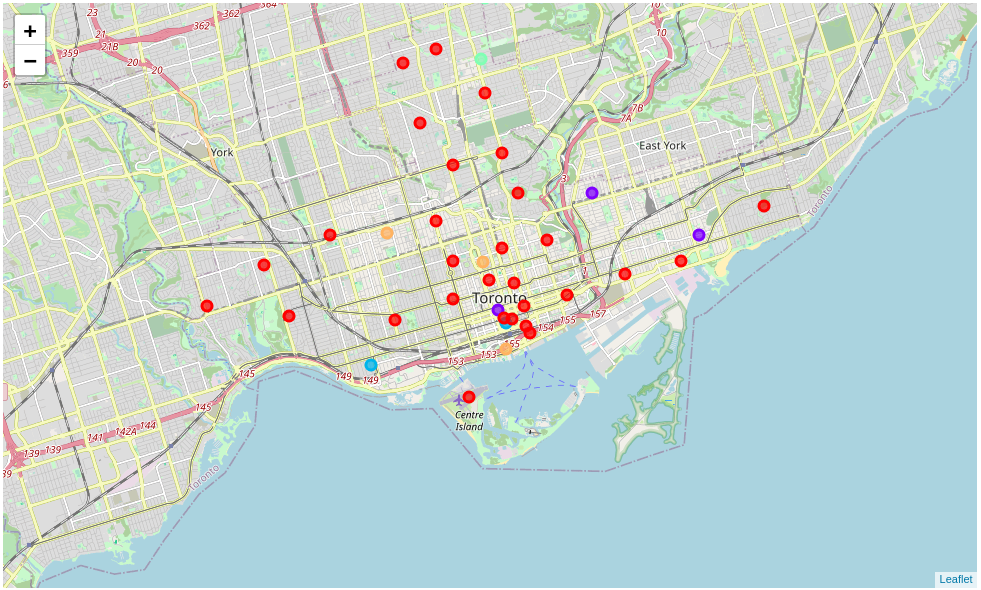